Program written by: Ningyou Li, 20307142; This program 

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
import sys
import nrrd
import os
%config Completer.use_jedi = False

In [188]:
# read image
img = sitk.ReadImage('Case11.mhd')
goldenStandard_img = sitk.ReadImage('Case11_segmentation.mhd')

In [3]:
def image_Info(image):
    """
    :param image: the input image read by SimpleITK
    :return: None
    This function prints the properties of the image. Properties include: size, spacing, origin, direction, pixel type
    """
    print('Size:', image.GetSize()) #size
    print('Space:', image.GetSpacing()) #space
    print('Origin:', image.GetOrigin()) #origin
    print('Direction:', image.GetDirection()) #direction
    print('Pixel Type:', image.GetPixelIDTypeAsString()) #pixel type
    
image_Info(img)

Size: (512, 512, 45)
Space: (0.312499, 0.312502, 2.79998)
Origin: (-99.4454, -77.9882, -58.7955)
Direction: (0.999637, -7.58933e-19, 0.0269276, 0.00448624, 0.986045, -0.166417, -0.0265512, 0.166477, 0.985688)
Pixel Type: 16-bit signed integer


In [4]:
# some information about pixels
stat_filter = sitk.StatisticsImageFilter()
stat_filter.Execute(img) #the output is not an image object but it has information
print('min pixel value: ',stat_filter.GetMinimum())
print('max pixel value: ',stat_filter.GetMaximum())

min pixel value:  0.0
max pixel value:  27479.0


In [5]:
image_Info(goldenStandard_img)

Size: (512, 512, 45)
Space: (0.312499, 0.312502, 2.79998)
Origin: (-99.4454, -77.9882, -58.7955)
Direction: (0.999637, -1.51787e-18, 0.0269276, 0.00448624, 0.986045, -0.166417, -0.0265512, 0.166477, 0.985688)
Pixel Type: 8-bit signed integer


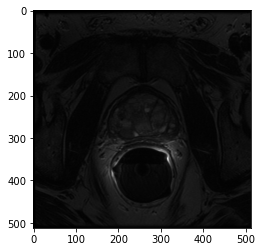

In [6]:
plt.imshow(sitk.GetArrayFromImage(img[:,:,22]), cmap='gray') 

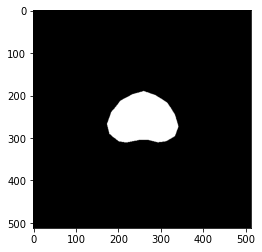

In [281]:
plt.imshow(sitk.GetArrayFromImage(goldenStandard_img[:,:,22]), cmap='gray') 

In [10]:
# Set external viewer to 3D slicer and Open with external viewer
image_viewer = sitk.ImageViewer()
image_viewer.SetApplication('C:/Users/Linda/AppData/Local/NA-MIC/Slicer 4.11.20210226/Slicer.exe')
image_viewer.Execute(img)

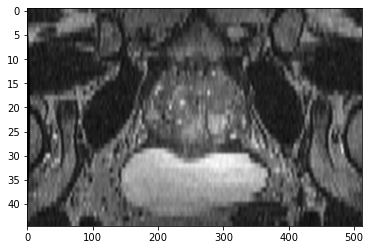

In [9]:
plt.imshow(sitk.GetArrayFromImage(img[:,256,:]),cmap='gray', aspect='auto') 

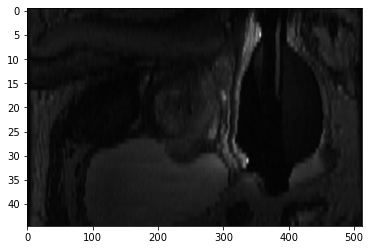

In [10]:
plt.imshow(sitk.GetArrayFromImage(img[256,:,:]),cmap='gray',aspect='auto') 

In [179]:
def prostate_segmenter(image, glambda=0.2, seed_pts=[(256,252,22)], Multiplier=1.31):
    slice_no = round(image.GetSize()[2]/2)
    img = sitk.Cast(image, sitk.sitkFloat32)
    # brighten the image using gamma filter to show more details in dark
    filtered_img = ((image/255)**glambda) # lambda<0
    gamma_img = sitk.RescaleIntensity(filtered_img,0,255)
    
    # Use region growing to segment the prostate
    growing_filter = sitk.ConfidenceConnectedImageFilter()
    growing_filter.SetSeedList(seed_pts)
    # set range of pixel intensity
    growing_filter.SetMultiplier(Multiplier)
    growed_img = growing_filter.Execute(gamma_img)
    plt.figure(figsize=(10,5))
    plt.imshow(sitk.GetArrayFromImage(growed_img[:,:,slice_no]))
    return growed_img

In [180]:
def saveSegmentation(growed_image):
    writer = sitk.ImageFileWriter()
    writer.SetFileName('my_segmentation.nrrd')
    writer.Execute(growed_image)

In [215]:
def overlay_visulize(image, mask_img):
    slice_no = round(image.GetSize()[2]/2)
    overlay_image = sitk.LabelOverlay(image[:,:,slice_no], mask_img[:,:,slice_no])
    plt.figure(figsize=(10,5))
    #plt.imshow(out.astype('uint8'))
    plt.imshow(sitk.GetArrayFromImage(overlay_image).astype(np.uint8))

# overlay图像有点问题

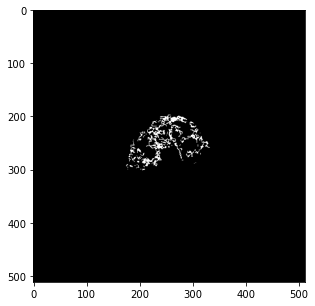

In [194]:
filtered_img = prostate_segmenter(img)

In [191]:
saveSegmentation(filtered_img)

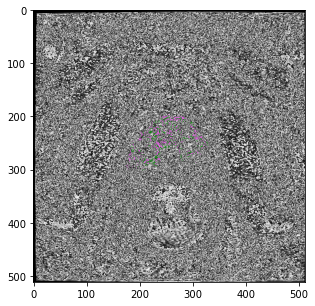

In [216]:
overlay_visulize(img, filtered_img)

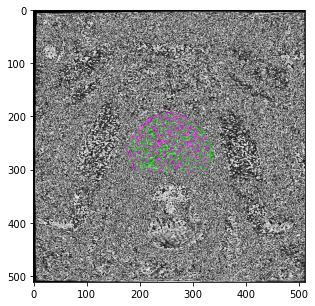

In [211]:
overlay_visulize(img, goldenStandard_img)

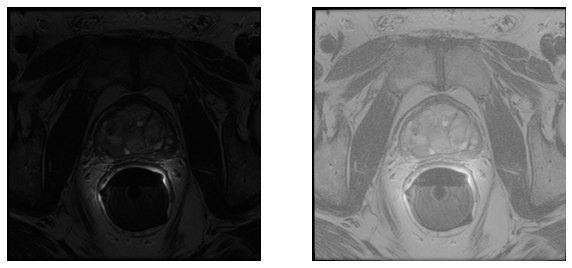

In [84]:
# gamma correction
img = sitk.Cast(img, sitk.sitkFloat32)
filtered_img = ((img/255)**0.2) # lambda<0, brighten the image: show more details in dark
gamma_img = sitk.RescaleIntensity(filtered_img,0,255)

plt.figure(figsize=(10,5))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(img[:,:,22]))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(gamma_img[:,:,22])) # vmax should be tunned based on the nature of the filtered image
plt.axis('off')
plt.show()

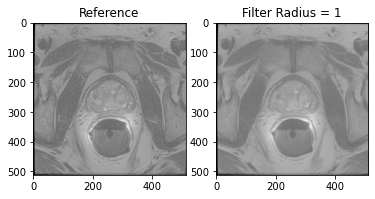

In [165]:
# Median smoothing, kernal radius = 3
median_filter = sitk.MedianImageFilter()
median_filter.SetRadius(1)
smoothed_img = median_filter.Execute(gamma_img)

# Show reference image and filtered images
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(gamma_img[:,:,22]))
plt.title('Reference')
#plt.show()
plt.subplot(122)
#plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(smoothed_img[:,:,22])) # vmax should be tunned based on the nature of the filtered image
plt.title('Filter Radius = 1')
plt.show()
#image_viewer.Execute(smoothed_img)

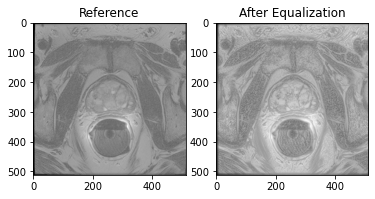

In [8]:
hist_equal_filter = sitk.AdaptiveHistogramEqualizationImageFilter()
hist_equal_filter.SetAlpha(0.1)
hist_equal_filter.SetBeta(5.5)
hist_equal_filter.SetRadius(5)
equalied_img = hist_equal_filter.Execute(gamma_img)

# Show reference image and filtered images
plt.subplot(121)
plt.gray()
plt.imshow(sitk.GetArrayFromImage(gamma_img[:,:,22]))
plt.title('Reference')
plt.subplot(122)
plt.imshow(sitk.GetArrayFromImage(equalied_img[:,:,22])) # vmax should be tunned based on the nature of the filtered image
plt.title('After Equalization')
plt.show()

In [11]:
image_viewer.Execute(equalied_img)

In [81]:
img_array = sitk.GetArrayFromImage(img)
mask_array = np.zeros(img_array.shape)
c = [270,270,22]
r = 110
for i in range(mask_array.shape[0]):
    for j in range(mask_array.shape[1]):
        for j in range(mask_array.shape[2]):
            if ( (i-c[0])**2+(j-c[1])**2+(k-c[1])**2 ) < r**2:
                mask_array[i,j,k] = 1
            
plt.imshow(mask_array*img_array)
masked_img_array = mask_array*img_array
masked_img = sitk.GetImageFromArray(masked_img_array)

IndexError: tuple index out of range

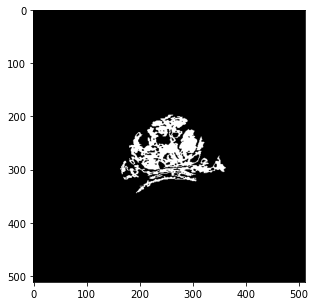

In [67]:
img = sitk.Cast(masked_img, sitk.sitkFloat32)
filtered_img = ((img/255)**0.2) # lambda<0, brighten the image: show more details in dark
gamma_img = sitk.RescaleIntensity(filtered_img,0,255)

seed_pts = [(262,232,22)]
#F4:(425,4463,4);F3:(236,4837,4); F2:(329,4400,4);F1:(327,6519,4)
growing_filter = sitk.ConfidenceConnectedImageFilter()
# set seed
growing_filter.SetSeedList(seed_pts)
# set range of pixel intensity
growing_filter.SetMultiplier(1.6)
growing_filter.SetNumberOfIterations(4)
con_growed_img1 = growing_filter.Execute(gamma_img)
plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(con_growed_img1))

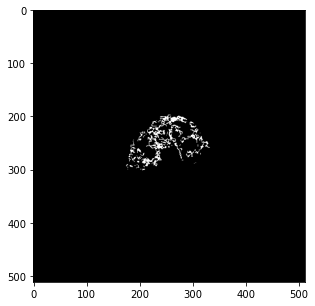

In [168]:
# Use region growing to segment the prostate
seed_pts = [(256,252,22)]#(266,236,22), (217,230,22),
growing_filter = sitk.ConfidenceConnectedImageFilter()
# set seed
growing_filter.SetSeedList(seed_pts)
# set range of pixel intensity
growing_filter.SetMultiplier(1.31)
growed_img = growing_filter.Execute(gamma_img)

plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(growed_img[:,:,22]))

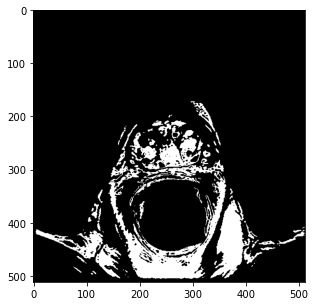

In [107]:
# Use ConnectedThresholdImageFilter() to grow region
ConnectedThresholdImageFilter = sitk.ConnectedThresholdImageFilter()
ConnectedThresholdImageFilter.SetLower(135)
ConnectedThresholdImageFilter.SetUpper(150)
ConnectedThresholdImageFilter.SetSeedList([(217,261,22),(295,255,22)]) 

threshold_img = ConnectedThresholdImageFilter.Execute(gamma_img)

plt.figure(figsize=(10,5))
plt.imshow(sitk.GetArrayFromImage(threshold_img[:,:,22]))

119.2626953125


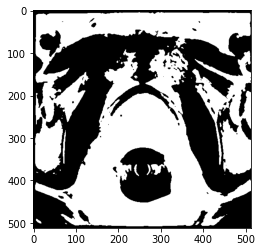

In [163]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
seg = otsu_filter.Execute(smoothed_img)
plt.imshow(sitk.GetArrayFromImage(seg[:,:,22]))
#plt.imshow(sitk.LabelOverlay(img[:,:,22], seg[:,:,22]), "Otsu Thresholding")
print(otsu_filter.GetThreshold())


# Part b

In [225]:
# def seg_eval_dice(filtered_img, img):
#     seg_array = sitk.GetArrayFromImage(filtered_img)
#     img_array = sitk.GetArrayFromImage(img)
#     assert (len(seg_array.shape)== len(img_array.shape))
#     prod = np.multiply(seg_array, img_array)
#     s0 = prod.sum()
#     dice = (2.0 * s0 + 1e-10) / (seg_array.sum() + img_array.sum() + 1e-10)
#     return dice

In [246]:
def seg_eval_dice(filtered_img, img):
    dice_dist = sitk.LabelOverlapMeasuresImageFilter()
    dice_dist.Execute(img>0.5, filtered_img>0.5)
    dice = dice_dist.GetDiceCoefficient()
    print(dice)
    return dice

In [255]:
def seg_eval_hausdorff(filtered_img, img):
    hausdorffcomputer = sitk.HausdorffDistanceImageFilter()
    hausdorffcomputer.Execute(img>0.5, filtered_img>0.5)
    #AverageHD = hausdorffcomputer.GetAverageHausdorffDistance()
    HD = hausdorffcomputer.GetHausdorffDistance()
    print(HD)
    return HD

In [249]:
seg_eval_dice(filtered_img, img)

0.05654140382415738

In [250]:
seg_eval_dice(goldenStandard_img, img)

0.47133040245539853

In [256]:
seg_eval_hausdorff(filtered_img, img)

107.11789231473128


107.11789231473128

In [257]:
seg_eval_hausdorff(goldenStandard_img, img)

105.10410644156092


105.10410644156092

# Part C


In [303]:
def findMaxArea(seg_img):
    #img_array = sitk.GetArrayFromImage(seg_img)
    area = 0
    area_lst = []
    for slice_no in range(seg_img.GetSize()[2]):
        img_array = sitk.GetArrayFromImage(seg_img[:,:,slice_no])
        pixels = len(np.column_stack(np.where(img_array > 0)))
        # Calculate the area of the prostate
        new_area = (seg_img[:,:,slice_no].GetSpacing()[0]*seg_img[:,:,slice_no].GetSpacing()[1])*pixels
        area_lst.append(new_area)
    print(max(area_lst))
    slices = area_lst.index(max(area_lst))
    return slices

In [304]:
findMaxArea(seg_img)

1579.887868092644


21

In [307]:
def get_target_loc(seg_img):
    slide_no = findMaxArea(seg_img)
    segImage_array = sitk.GetArrayFromImage(seg_img[:,:,slide_no])
    x = np.mean(np.column_stack(np.where(segImage_array > 0)[0]))
    y = np.mean(np.column_stack(np.where(segImage_array > 0)[1]))
    print((x,y,slide_no))
    return (x,y,slide_no)

In [308]:
get_target_loc(goldenStandard_img)

1579.887868092644
(255.87198664853506, 257.1432809988874, 21)


(255.87198664853506, 257.1432809988874, 21)

In [ ]:
def overlay_target(coordinate, seg_img, image):
    plt.imshow(segImage_array, cmap='gray')
    #overlay X on target location
    overlay_threshold = sitk.LabelOverlay(img, threshold_img)
    plt.figure(figsize=(10,5))
    plt.imshow(sitk.GetArrayFromImage(overlay_confident))
    # 咋在image上面画叉

# Part D

In [ ]:
def pixel_extract(image, point, width):